<a href="https://colab.research.google.com/github/anuva05/PracticalDeepLearningCourse/blob/master/Lesson3_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image segmentation with CamVid dataset



We're going to segment images from the CamVid dataset (Brostow et al.) so that each object in the image is the same color. 
The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented. Because we’re predicting for every pixel in the image, this task is commonly referred to as dense prediction. The output itself is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class. Thus it is a pixel level image classification.
The CamVid dataset has images and segmentation masks. For segmentation, an architecture called U-Net works better than CNN (U-Net was originally created for biomedical image segmentation).

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [1]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git


Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 14.53 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [2]:
! ls SegNet-Tutorial/CamVid

test  testannot  test.txt  train  trainannot  train.txt  val  valannot	val.txt


In [5]:
path = Path('SegNet-Tutorial/CamVid')
path.ls()

[PosixPath('SegNet-Tutorial/CamVid/train'),
 PosixPath('SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('SegNet-Tutorial/CamVid/valannot'),
 PosixPath('SegNet-Tutorial/CamVid/val'),
 PosixPath('SegNet-Tutorial/CamVid/test'),
 PosixPath('SegNet-Tutorial/CamVid/testannot'),
 PosixPath('SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('SegNet-Tutorial/CamVid/trainannot')]

Let us take a look at some images and their annotations from this dataset. As you can see, it contains images and their ground-truth segmentation masks. 

In [6]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08031.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08105.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08097.png')]

In [7]:
#Labeled images
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08031.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08105.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08097.png')]

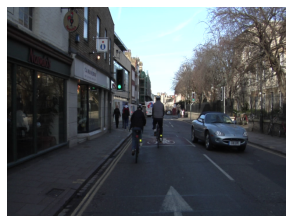

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
#Function to get annotated image/segmentation mask
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

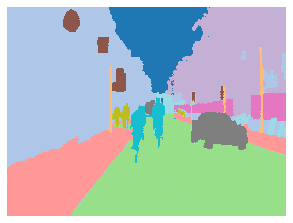

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

Taking a look at the dataset.. 

In [0]:
#set batch size 
bs = 8

In [0]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

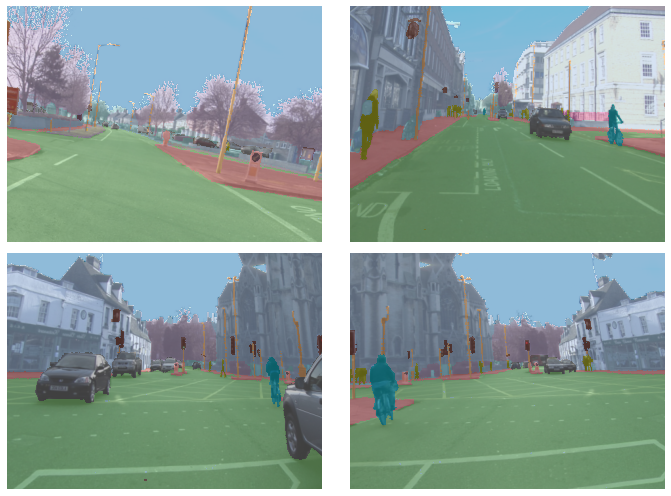

In [15]:
data.show_batch(2, figsize=(10,7))

#Set up the model

In [0]:
#Creating a name-id mapping 
#Some labels in this dataset are set to 'Void' for some reason, so accounting for that.
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

#The following function computes accuracy of the segmented result based on the ground truth labels
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
#the function given above will be used as a metric
metrics=acc_camvid
wd=1e-2

We will be using the U-Net architecture, which has been shown to be very useful for semantic segmentation.

In [18]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


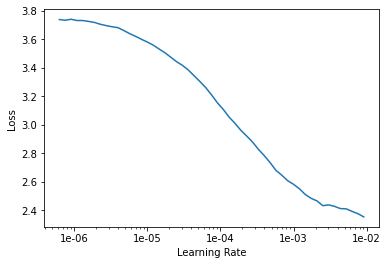

In [19]:
lr_find(learn)
learn.recorder.plot()

In [0]:
#A good choice might be..
lr=2e-3

In [21]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.217881,0.873797,0.768081,00:28
1,0.820348,0.614911,0.845876,00:25
2,0.646227,0.523502,0.863419,00:25
3,0.577834,0.503689,0.857596,00:25
4,0.507749,0.399001,0.879233,00:25
5,0.469551,0.442416,0.876378,00:25
6,1.285225,1.473266,0.610279,00:25
7,1.225468,1.041046,0.740479,00:25
8,1.023325,0.744913,0.772136,00:25
9,0.756828,0.574813,0.845354,00:25


In [0]:
learn.save('stage-1')

The accuracy came upto about 84%. Also, in some cases training loss is larger than validation loss, which means we are underfitting our model. We can try to correct this by running for more epochs. We can do better after fine tuning. Fine tuning our model by unfreezing it and training the initial layers with a new, better learning rate..

In [0]:
learn.load('stage-1')

In [0]:
learn.unfreeze()

In [0]:
#Provide a range of learning rates to use
lrs = slice(lr/100,lr)

In [26]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.511723,0.508904,0.863410,00:27
1,0.471702,0.467637,0.871466,00:26
2,0.429675,0.374353,0.886716,00:26
3,0.391756,0.367377,0.887517,00:26
4,0.367641,0.320080,0.906569,00:26
5,0.361003,0.359562,0.895556,00:26
6,0.351373,0.377959,0.901689,00:26
7,0.325911,0.352389,0.880471,00:26
8,0.309327,0.351488,0.890668,00:26
9,0.323959,0.333676,0.900412,00:26


In [0]:
learn.save('stage-2');

Now we have an accuracy of 92%, and looks like we are not underfitting! 

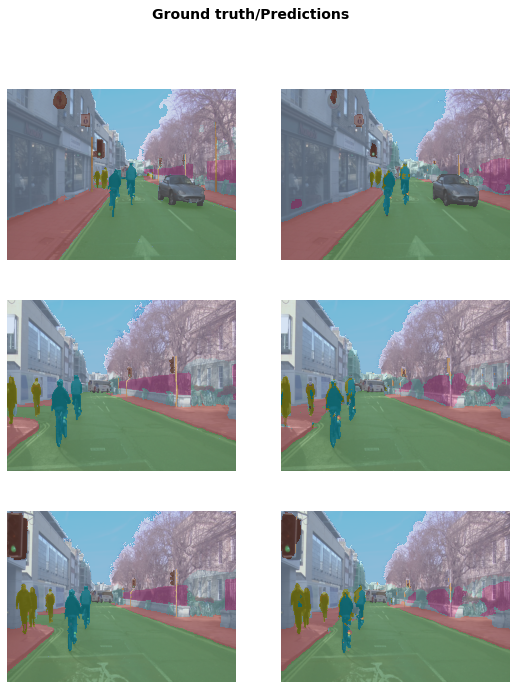

In [28]:
#Display some results
learn.show_results(rows=3, figsize=(9,11))